# Extract dataset from Kaggle

Since this ipynb is inside Kaggle, we won't do dataset extraction. Instead we will tell the notebook where the dataset location is.

In [1]:
import os

dataset_dir = '/kaggle/input/datasets/puneet6060/intel-image-classification'
for dirname, dirnames, filenames in os.walk(dataset_dir):
    print(f"Directory: {dirname}")
    if filenames:
        print(f"  -- Contains {len(filenames)} files")

Directory: /kaggle/input/datasets/puneet6060/intel-image-classification
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain
  -- Contains 2512 files
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/street
  -- Contains 2382 files
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/buildings
  -- Contains 2191 files
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/sea
  -- Contains 2274 files
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/forest
  -- Contains 2271 files
Directory: /kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/glacier
  -- Contains 2404 files
Directo

# Preprocessing

In [2]:
# Check Class
import os

# Print out the directory of the train folder
train_dir = dataset_dir + '/seg_train/seg_train'
train_dir_list = os.listdir(train_dir)
total_train = 0
for x in train_dir_list:
    amount = len(os.listdir(f"{train_dir}/{x}"))
    print(f"{x} has {amount} datasets")
    total_train += amount
print(f"Total Train Sets: {total_train}")

mountain has 2512 datasets
street has 2382 datasets
buildings has 2191 datasets
sea has 2274 datasets
forest has 2271 datasets
glacier has 2404 datasets
Total Train Sets: 14034


In [3]:
# Print out the directory of the test folder
test_dir = dataset_dir + '/seg_test/seg_test'
test_dir_list = os.listdir(test_dir)
total_test = 0
for x in test_dir_list:
    amount = len(os.listdir(f"{test_dir}/{x}"))
    print(f"{x} has {amount} datasets")
    total_test += amount
print(f"Total Test Sets: {total_test}")

mountain has 525 datasets
street has 501 datasets
buildings has 437 datasets
sea has 510 datasets
forest has 474 datasets
glacier has 553 datasets
Total Test Sets: 3000


In [4]:
# Read the class indices to process the output
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=(150, 150)
)
classes = train_dataset.class_names
print(classes)

2026-02-21 16:10:27.317189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771690227.508318      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771690227.561128      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771690228.023423      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771690228.023464      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771690228.023467      24 computation_placer.cc:177] computation placer alr

Found 14034 files belonging to 6 classes.


I0000 00:00:1771690254.005635      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Only apply augmentation to the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for test data
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [6]:
# Data Preparation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # 20% of train_dir
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)

Found 14034 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Modeling and Training

In [7]:
model = tf.keras.models.Sequential([
    # Block 1: Initial Feature Extraction
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2: Learning Textures
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3: Complex Patterns
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 4: High-Level Concepts (The "Deeper" Layers)
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 5: Fine Details
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense Head: Decision Making
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 9, 9, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,79

 Total params: 2,555,046 (9.75 MB)

 Trainable params: 2,553,062 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
class epochCallback(tf.keras.callbacks.Callback):
    min_reached, recommend_reached = False, False

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
            print("\nReached target accuracy of 95%")
            self.model.stop_training = True
        elif (logs.get('accuracy') >= 0.85 and logs.get('val_accuracy') >= 0.85 and self.recommend_reached == False):
            print("\nReached recommended accuracy of 85%")
            self.recommend_reached = True

callbacks = epochCallback()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1771690262.628968      73 service.cc:152] XLA service 0x7d414010e6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771690262.629007      73 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771690263.562571      73 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/439 ━━━━━━━━━━━━━━━━━━━━ 1:46:34 15s/step - accuracy: 0.0938 - loss: 1.9335

I0000 00:00:1771690272.530398      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 130s 263ms/step - accuracy: 0.4695 - loss: 1.3655 - val_accuracy: 0.4914 - val_loss: 1.5138 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 195ms/step - accuracy: 0.6550 - loss: 0.9356 - val_accuracy: 0.6630 - val_loss: 0.9522 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 206ms/step - accuracy: 0.7040 - loss: 0.8244 - val_accuracy: 0.6509 - val_loss: 0.8799 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 204ms/step - accuracy: 0.7401 - loss: 0.7081 - val_accuracy: 0.5606 - val_loss: 1.4295 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 192ms/step - accuracy: 0.7552 - loss: 0.6850 - val_accuracy: 0.5160 - val_loss: 2.0037 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 191ms/step - accuracy: 0.7778 - loss: 0.6404 - val_accuracy: 0.8381 - val_loss: 0.4856 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.7975 - loss

# Saving Model

In [9]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.31.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-adk 1.21.0 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
ray 2.53.0 requires packaging>=24.2, but you have packaging 23.2 which is incompatible.
build 1.4.0 requires packaging>=24.0, but you have packaging 23.2 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires pandas==

In [10]:
import shutil
import tensorflowjs as tfjs

# Create the main submission directory and subfolders
base_dir = '/kaggle/working/submission'
subfolders = ['tfjs_model', 'tflite', 'saved_model']
for folder in subfolders:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

# Save TF Model
print("Saving TF Model...")
model.export(os.path.join(base_dir, 'saved_model'))
print("  -- Saved TF Model\n")

# Save TFLite & Label
print("Saving TFLite Model...")
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(base_dir, 'saved_model'))
tflite_model = converter.convert()

with open(os.path.join(base_dir, 'tflite', 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

with open(os.path.join(base_dir, 'tflite', 'label.txt'), 'w') as f:
    f.write('\n'.join(classes))

print("  -- Saved TFLite Model\n")

# Save TFJS Model
print("Saving TFJS Model...")
tfjs.converters.save_keras_model(model, os.path.join(base_dir, 'tfjs_model'))
print("  -- Saved TFJS Model\n")

print("Successfully saved model!")

Saving TF Model...
INFO:tensorflow:Assets written to: /kaggle/working/submission/saved_model/assets


INFO:tensorflow:Assets written to: /kaggle/working/submission/saved_model/assets


Saved artifact at '/kaggle/working/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137725297443088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163571088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163571664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163567824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163568400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163569360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163570128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163571280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163572240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137722163569552: TensorSpec(shape=(), dtype=tf.resource, name=

W0000 00:00:1771694498.503152      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771694498.503218      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1771694498.534759      24 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


  -- Saved TFLite Model

Saving TFJS Model...
failed to lookup keras version from the file,
    this is likely a weight only file
  -- Saved TFJS Model

Successfully saved model!


# Training Analysis

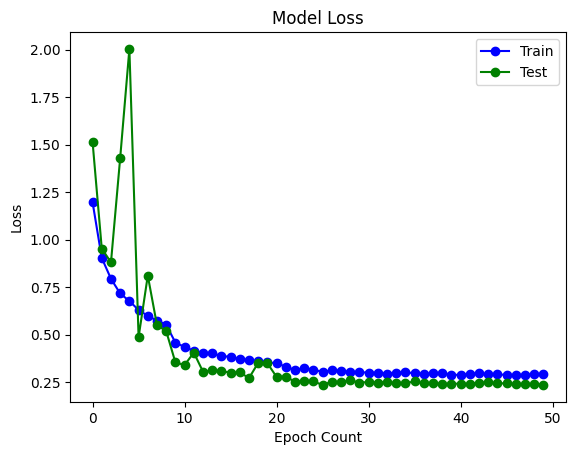

In [11]:
# Loss Graph
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'bo-')
plt.plot(history.history['val_loss'], 'go-')
plt.title('Model Loss')
plt.xlabel('Epoch Count')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

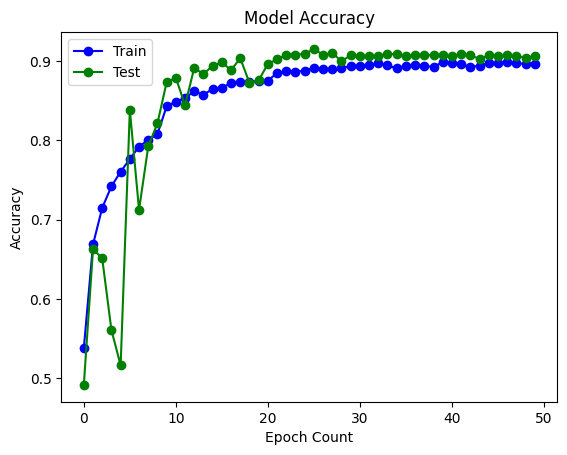

In [12]:
# Accuracy Graph

plt.plot(history.history['accuracy'], 'bo-')
plt.plot(history.history['val_accuracy'], 'go-')
plt.title('Model Accuracy')
plt.xlabel('Epoch Count')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Model Testing (Inference)

In [13]:
print("Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

Evaluating on Test Set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.8972 - loss: 0.2924

Final Test Accuracy: 89.37%
Final Test Loss: 0.3123


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


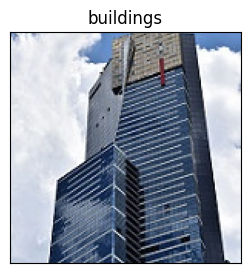

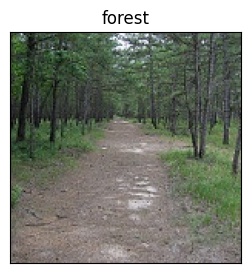

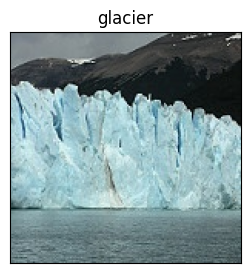

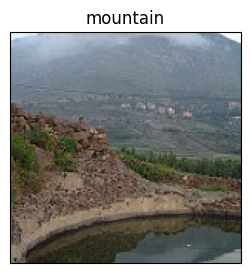

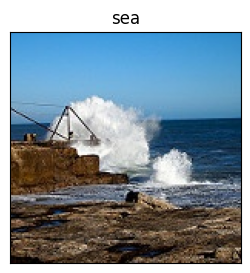

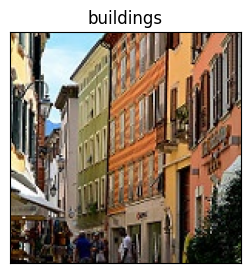

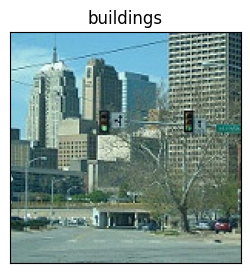

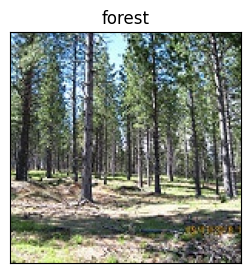

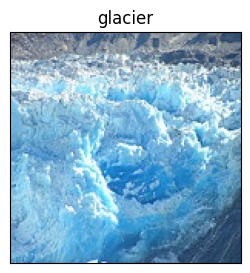

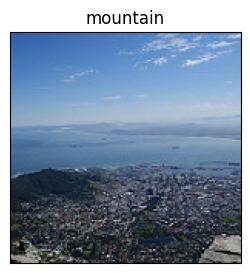

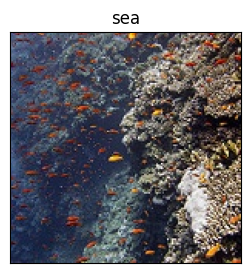

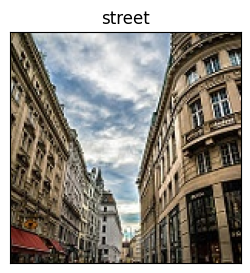

In [14]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

# Some sampling from the test set
fn = [
    "seg_test/seg_test/buildings/20057.jpg",
    "seg_test/seg_test/forest/20056.jpg",
    "seg_test/seg_test/glacier/20059.jpg",
    "seg_test/seg_test/mountain/20058.jpg",
    "seg_test/seg_test/sea/20072.jpg",
    "seg_test/seg_test/street/20066.jpg",
    "seg_test/seg_test/buildings/20060.jpg",
    "seg_test/seg_test/forest/20062.jpg",
    "seg_test/seg_test/glacier/20087.jpg",
    "seg_test/seg_test/mountain/20068.jpg",
    "seg_test/seg_test/sea/20076.jpg",
    "seg_test/seg_test/street/20067.jpg",
]

for i in range(len(fn)):
    img = plt.imread(dataset_dir + '/' + fn[i])
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    img = img/255.0
    predict = model.predict(np.expand_dims(img, axis=0))
    result = np.squeeze(predict)
    plt.title(classes[np.argmax(result)])
    plt.xticks([])
    plt.yticks([])